# Clasificación multiclase de especies de aves en imágenes 

#### Presentado por:

Andrés M. Obando 201819251

Luis C. Peña 201819257

Alexander Vega 200814739

En este notebook abordamos el problema de clasificar aves por especie, mediante una clasificación múltiple de imágenes. Contando con datos de imágenes para 6 especies de aves, para cada una de estas se tienen 100 imágenes. Debido al bajo volumen de datos de cada especie, utilizaremos un algoritmo de transferencia de aprendizaje llamado VGG16 que nos permite tener una mayor exactitud al ser un algoritmo pre-entrenado.


## Carga y alistamiento de datos

In [1]:
import os 
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import random

# Extraer las imagenes del archivo zip
with zipfile.ZipFile("birds.zip","r") as zip_ref:
    zip_ref.extractall(os.getcwd())

Using TensorFlow backend.


Verificamos cargando una de las imágenes extraidas.

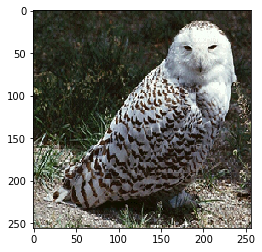

In [4]:
# Shows an image example of training set.
img = load_img('birds/owl/owl016.jpg',grayscale=False,target_size=(256,256),interpolation='nearest') 
x= img_to_array(img)
plt.imshow(x/255)


Teniendo las imágenes extraídas, debemos estandarizar su tamaño, dividir el set de datos en Train y Test y luego almacenarlas en un array de datos para que sean comprendidos por el modelo.

In [0]:
# Creamos una lista aleatoria oredenada. .
np.random.seed(1234)
randomList= random.sample(range(1,101),100)
formating = "{:03d}".format
formatedList = [formating(item) for item in randomList]

In [0]:
from PIL import Image
#Definimos el tamaño con el que estandarizamos las imgenes
xsize = 299
ysize = 299

# definimos el nombre de cada una de las especies de acuerdo a como se encuentran calasificadas en los datos
paths=['egret','mandarin','owl','puffin','toucan','wood_duck']
maxImage= 80

pre=''
birdKind=-1
xL=[]
yL=[]


# definimos las rutas de lectura de las imagenes, para luego redimensionarlas y separarlas en Train y Test.
for j in paths[:]:
    if(j=='egret'):
        pre='/egr'
        birdKind=0
    elif(j=='mandarin'):
        pre='/man'
        birdKind=1
    elif(j=='owl'):
        pre='/owl'
        birdKind=2
    elif(j=='puffin'):
        pre='/puf'
        birdKind=3
    elif(j=='toucan'):
        pre='/tou'
        birdKind=4
    elif(j=='wood_duck'):
        pre='/wod'
        birdKind=5

        
    counter=0
    for i in formatedList[:]:
        
        # Redimensionamos las imagenes 299X299
        img = Image.open('birds/'+j+pre+i+'.jpg')
        wpercent = (xsize/float(img.size[0]))
        img = img.resize((xsize,ysize), Image.ANTIALIAS)
        img.save('birds/'+j+pre+i+'.jpg')
        
        # Cargar las imagenes redimensionadas en un array de datos.
        img = load_img('birds/'+j+pre+i+'.jpg',grayscale=False,target_size=(xsize,ysize),interpolation='nearest') 
        x= img_to_array(img)
        
        xL.append(x)
        yL.append(birdKind)
        counter=counter+1


# Convertir las listas en arrays.
xList=np.asarray(xL)
yList=np.asarray(yL)

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
np.random.seed(1234)

# Aplicar Encode a cada uno de los valores de las clases para convertirlos en enteros.
encoder = LabelEncoder()
encoder.fit(yList)
encoded_Y = encoder.transform(yList)

# Convertimos los valores enteros de clase en variables dummies
y = np_utils.to_categorical(encoded_Y)

# Realizamos la particion de datos en train y test
xTrain,xTest,yTrain,yTest = train_test_split(xList, y, test_size=0.3, random_state=22)

## Uso del modelo pre-entrenado

### Modelo VGG16 

La arquitectura de la red VGG fue inroducida por Simonyan y Zisserman en su artículo de 2014, Redes Convolucionales Profundas para el reconocimiento de imágenes a gran escala. Esta red se caracteriza por su simplicidad, utilizando solo capas convolucionales de 3 × 3 apiladas una encima de la otra en profundidad creciente.

![Xception Structure](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)


Importamos el modelo VGG16 que se encuentra pre-entrenado para procesar nuestros datos con este modelo y luego utilizarlos dentro del modelo que diseñemos.

In [0]:
from keras.applications.vgg16 import VGG16
modelXceptionTF = VGG16(weights='imagenet', include_top=False)

In [0]:
# Procesamos nuestro set de datos de entrenamiento con el modelo VGG16.
newXtrain=modelXceptionTF.predict(xTrain)

# # Procesamos nuestro set de datos de prueba con el modelo VGG16.
newXtest=modelXceptionTF.predict(xTest)

In [22]:
newXtrain.shape

(420, 9, 9, 512)

## Definicion de nuestro modelo

En nuestro caso obtuvimos el mejor resultado mediante el uso de un modelo secuencial de dos capas ocultas, la primera con función de activación Relu y para la segunda función de activación Softmax. En este caso usamos el optimizador Adam con un learning rate de 0.0001, nuestra función de costo categorical_crossentropy.

In [0]:
!pip install livelossplot

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import keras.optimizers as opts
from livelossplot import PlotLossesKeras
np.random.seed(1234)
K.clear_session()
# Model structure.
outputClasses = 6

# Create the model. 
cnn_transfer = Sequential()

# Apply a convolutional layer. 
cnn_transfer.add(Flatten(input_shape=newXtrain.shape[1:]))

# Add the fully connected.
cnn_transfer.add(Dense(256, activation='relu'))

# Add a dropout.
cnn_transfer.add(Dropout(0.6))


# Add the fully connected.
cnn_transfer.add(Dense(outputClasses))

# Add the activation softmax.
cnn_transfer.add(Activation('softmax'))

print(cnn_transfer.summary(70))



Model: "sequential_1"
______________________________________________________________________
Layer (type)                   Output Shape                Param #    
flatten_1 (Flatten)            (None, 41472)               0          
______________________________________________________________________
dense_1 (Dense)                (None, 256)                 10617088   
______________________________________________________________________
dropout_1 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_2 (Dense)                (None, 6)                   1542       
______________________________________________________________________
activation_1 (Activation)      (None, 6)                   0          
Total params: 10,618,630
Trainable params: 10,618,630
Non-trainable params: 0
______________________________________________________________________
None


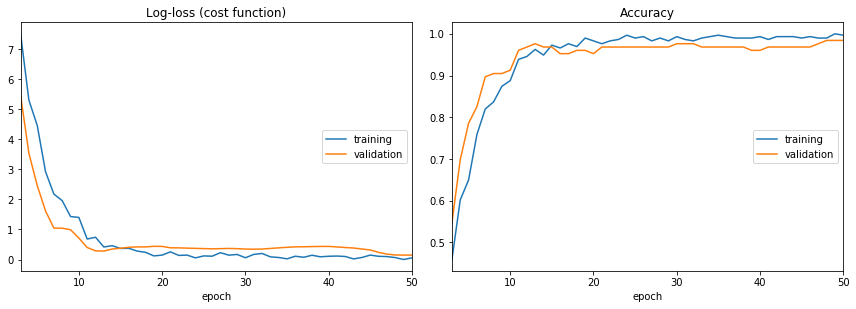

Log-loss (cost function):
training   (min:    0.000, max:   12.420, cur:    0.055)
validation (min:    0.147, max:   10.302, cur:    0.148)

Accuracy:
training   (min:    0.156, max:    1.000, cur:    0.997)
validation (min:    0.270, max:    0.984, cur:    0.984)


In [28]:
# Compilamos nuestro modelo definiedo primero el optimizador, la funcion de perdida y la metrica que utilizaremos. 
op=opts.Adam(lr=0.0001,epsilon=None, decay=0.0)
cnn_transfer.compile(loss = 'categorical_crossentropy',
              optimizer = op,
              metrics = ['accuracy'])

#Definimos la cantidad de epocas y el tamaño de los batch
batch_size = 150
epochs = 50

# para validar nuestro modelos dividimos nuestro set de train indicando para este caso que el 30% de los datos 
# los usaremos para validacion y graficamos los resultados 
trainingCNN_Transfer = cnn_transfer.fit(newXtrain, yTrain,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle = True, 
                    validation_split = 0.30,
                    callbacks=[PlotLossesKeras()])


## Validacion de nuestro modelo con el set de Test

In [24]:
# Perform the neural network over the test set. 
print('Evaluating the test set...')
score = cnn_transfer.evaluate(newXtest, yTest)

print('\nTest score:', score[0])
print('Test accuracy:', score[1])

Accu_VGG16=score[1]
Accu_VGG16

Evaluating the test set...
180/180 [==============================] - 0s 159us/step

Test score: 0.5450259880887137
Test accuracy: 0.9444444417953491


0.9444444417953491

Con el modelo definido logramos un accuracy del 94% sobre los datos de Test y 0.54 de perdida como resultado de nuestra función de costos.


Construiremos nuestra matriz de confusión para validar la efectividad por especie.

In [29]:
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import numpy as np

# Set the classes' names.
target_names = ['egr','man','owl','puf','tou','wod']

# Predict class in test.
Y_pred = cnn_transfer.predict(newXtest)

# Choose the class with higher probability.
y_pred = np.argmax(Y_pred, axis=1)

print('-------------------------------------------------')
print('-------------------------------------------------')
print('-----------------Confusion Matrix----------------')
print(pd.DataFrame(confusion_matrix(yTest.argmax(axis=1), y_pred),columns=target_names, index=target_names))
print('-------------------------------------------------')
print('-------------------------------------------------\n')
print('---------------Classification Report-------------')

print(classification_report(yTest.argmax(axis=1), y_pred, target_names=target_names))

-------------------------------------------------
-------------------------------------------------
-----------------Confusion Matrix----------------
     egr  man  owl  puf  tou  wod
egr   29    0    0    0    0    0
man    0   29    0    0    1    3
owl    0    1   32    0    0    0
puf    0    3    0   31    0    0
tou    0    0    0    0   27    0
wod    0    2    0    0    0   22
-------------------------------------------------
-------------------------------------------------

---------------Classification Report-------------
              precision    recall  f1-score   support

         egr       1.00      1.00      1.00        29
         man       0.83      0.88      0.85        33
         owl       1.00      0.97      0.98        33
         puf       1.00      0.91      0.95        34
         tou       0.96      1.00      0.98        27
         wod       0.88      0.92      0.90        24

    accuracy                           0.94       180
   macro avg       0.95    

## Conclusiones